# **Recurrent Neural Network**

## **Spoken Digit Recognition (0–9) Using LSTM + MFCC**
A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

In [ ]:
# Import necessary libraries
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# 1) Download the dataset
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 34.38 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
DATA_DIR = "/content/free-spoken-digit-dataset/recordings"

In [ ]:
path="/content/free-spoken-digit-dataset/recordings/0_george_20.wav"

signal, sr = librosa.load(path, sr=8000) # sr: sampling rate

# Mel-frequency cepstral coefficients (MFCCs)
mfcc = librosa.feature.mfcc(
    y=signal, sr=sr, n_mfcc=20, n_fft=512, hop_length=128
)
len(mfcc)

20

In [ ]:
mfcc.shape

(20, 34)

In [ ]:
from IPython.display import Audio

Audio(path)

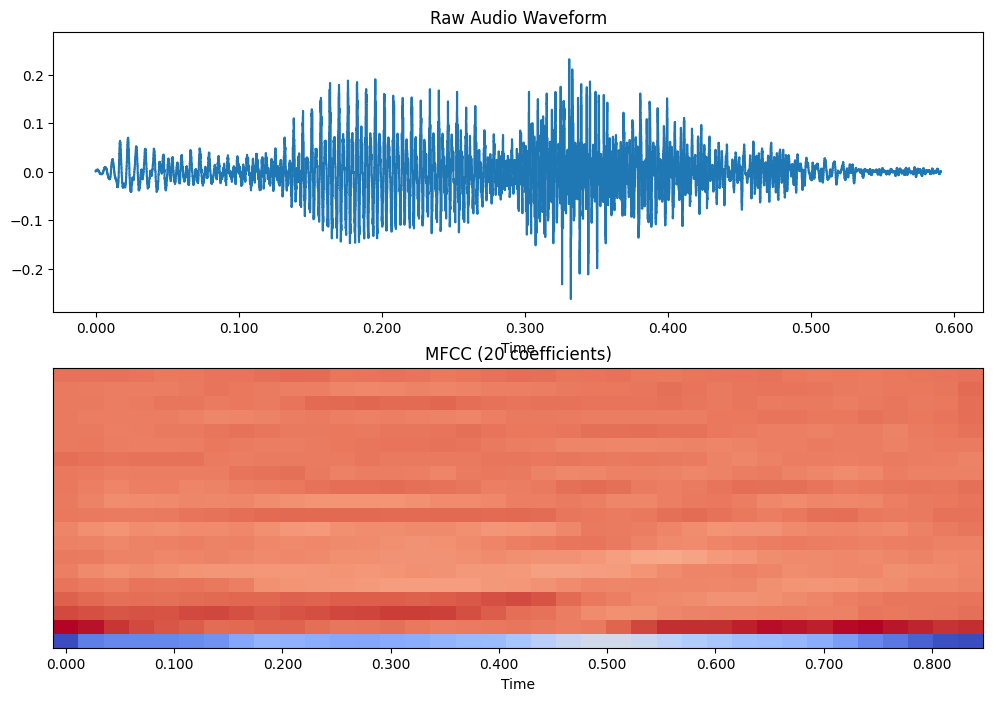

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# waveform
librosa.display.waveshow(signal, sr=sr, ax=ax[0])
ax[0].set_title("Raw Audio Waveform")

librosa.display.specshow(mfcc, x_axis="time", ax=ax[1])
ax[1].set_title("MFCC (20 coefficients)")
plt.show()

In [ ]:
# 2) Load MFCC features for all files
def load_fsdd():
    X, y = [], []

    for fname in os.listdir(DATA_DIR):
        if fname.endswith(".wav"):
            digit = int(fname.split("_")[0])
            path = os.path.join(DATA_DIR, fname)

            signal, sr = librosa.load(path, sr=8000)

            mfcc = librosa.feature.mfcc(
                y=signal, sr=sr, n_mfcc=20,
                n_fft=512, hop_length=128
            )

            X.append(mfcc.T)
            y.append(digit)

    return X, np.array(y)

X, y = load_fsdd()
print("Loaded samples:", len(X))
print("X shape:", X[50].shape)
print("Labels shape:", y.shape)

Loaded samples: 3000
X shape: (15, 20)
Labels shape: (3000,)


In [ ]:
# 3) Pad sequences to same length

max_timesteps = 100
X = pad_sequences(X, maxlen=max_timesteps, padding="post", dtype="float32")
print("X shape:", X.shape)

X shape: (3000, 100, 20)


In [ ]:
# 4) One-hot labels
num_classes = 10
y = tf.keras.utils.to_categorical(y, num_classes)
y.shape

(3000, 10)

In [ ]:
# 5) Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X[0].shape

(100, 20)

### ***What is Masking?***
Masking tells the LSTM which time steps are real data and which are just padding.

When we pad sequences like this:


```
[ [frame1, frame2, frame3, 0, 0, 0],
  [frame1, frame2, 0, 0, 0, 0],
  [frame1, frame2, frame3, frame4, frame5, frame6] ]
```
We use zeros (or another value) to make all sequences the same length.
But these zeros are NOT real audio — they are just placeholders.

Masking tells the LSTM to ignore these values.

When you add:
`layers.Masking(mask_value=0.)`
Keras automatically:
- Detects all-zero frames
- Marks them as "don’t process"
- Prevents the LSTM from updating its hidden state on those frames
- Prevents gradients from flowing through padded timesteps

This keeps the training clean and correct.


In [ ]:
# 6) LSTM model

model = tf.keras.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.Masking(mask_value=0.),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 100, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,506 (509.79 KB)

 Trainable params: 130,506 (509.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7) Train
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks=[EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
           ModelCheckpoint("spoken_digits_recognition.keras", monitor='val_accuracy', save_best_only=True)
               ]
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    callbacks=callbacks,
    batch_size=32
)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.2994 - loss: 2.0802 - val_accuracy: 0.7958 - val_loss: 0.7844
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.8271 - loss: 0.5907 - val_accuracy: 0.9292 - val_loss: 0.3014
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9377 - loss: 0.2272 - val_accuracy: 0.9062 - val_loss: 0.2986
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9420 - loss: 0.1814 - val_accuracy: 0.9646 - val_loss: 0.1283
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9673 - loss: 0.1195 - val_accuracy: 0.9500 - val_loss: 0.2412
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9741 - loss: 0.0903 - val_accuracy: 0.9667 - val_loss: 0.1231
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9846 - loss: 0.0649 - val_accuracy: 0.9563 - val_loss: 0.1770
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9925 - loss: 0.0368 - val_accuracy: 0

In [ ]:
# 8) Evaluate
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9745 - loss: 0.0931
Test accuracy: 0.9783333539962769


In [ ]:
# 9) Predict a single sample
import random
i = random.randint(0, len(X_test)-1)
pred = np.argmax(model.predict(X_test[i:i+1]))
true = np.argmax(y_test[i])

print("True:", true, "Predicted:", pred)

# Test Model Performance on my/your voice

In [ ]:
from IPython.display import Javascript, display
from google.colab import output
import base64

def record(sec=10, filename="myvoice.wav"):
    display(Javascript("""
        async function record(sec){
          const sleep = time => new Promise(resolve => setTimeout(resolve, time));
          const stream = await navigator.mediaDevices.getUserMedia({audio:true});
          const recorder = new MediaRecorder(stream);
          let data = [];

          recorder.ondataavailable = event => data.push(event.data);
          alert("Start recording ...")
          recorder.start();

          await sleep(sec * 1000);
          recorder.stop();
          alert("Done .. Saving in progress ...")
          await new Promise(resolve => recorder.onstop = resolve);

          const blob = new Blob(data);
          const reader = new FileReader();
          reader.readAsDataURL(blob);

          reader.onloadend = function() {
            google.colab.kernel.invokeFunction('notebook.receive_audio', [reader.result], {});
          };
        }
        record(%d);
    """ % sec))

    # callback in Python
    def _callback(audio_data):
        audio_bytes = base64.b64decode(audio_data.split(',')[1])
        with open(filename, "wb") as f:
            f.write(audio_bytes)
        print("Audio saved to", filename)

    output.register_callback('notebook.receive_audio', _callback)

print("Recorder ready.")


Recorder ready.


In [ ]:
record()

<IPython.core.display.Javascript object>

Audio saved to myvoice.wav


In [ ]:
Audio("myvoice.wav")

/tmp/ipython-input-1584131275.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  signal_, sr_ = librosa.load("myvoice.wav", sr=8000) # 8kHz
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1584131275.py:4: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(signal_,sr=sr, x_axis='time')


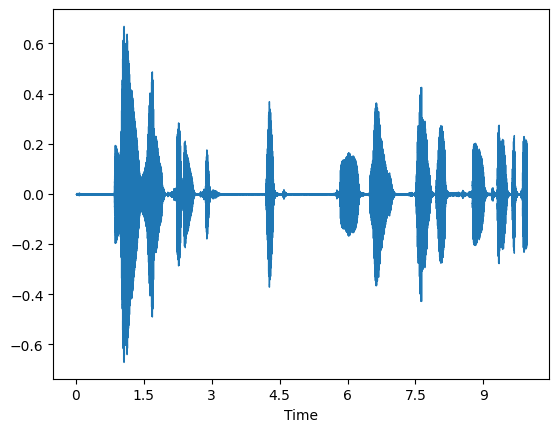

In [ ]:
# Extract MFCC and run prediction (just like before)
signal_, sr_ = librosa.load("myvoice.wav", sr=8000) # 8kHz

librosa.display.waveshow(signal_,sr=sr, x_axis='time')

/tmp/ipython-input-2918010783.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  signal_, sr_ = librosa.load("myvoice.wav", sr=8000) # 8kHz
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-2918010783.py:4: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(signal_,sr=sr, x_axis='time')
/tmp/ipython-input-2918010783.py:9: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(signal_,sr=sr, x_axis='time')


Padded shape: (37, 20)
Padded shape: (1, 100, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[3.6263307e-05 9.8186976e-01 2.8506875e-06 3.5944797e-06 1.0903417e-04
  9.3859201e-03 2.5703907e-06 2.5233377e-03 9.4269999e-05 5.9723747e-03]]
1


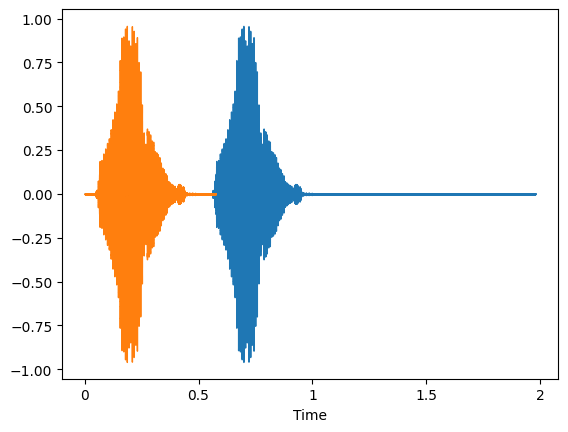

In [ ]:
# Extract MFCC and run prediction (just like before)
signal_, sr_ = librosa.load("myvoice.wav", sr=8000) # 8kHz

librosa.display.waveshow(signal_,sr=sr, x_axis='time')

# remove silence
signal_, _ = librosa.effects.trim(signal_, top_db=25)

librosa.display.waveshow(signal_,sr=sr, x_axis='time')

mfcc_ = librosa.feature.mfcc(
    y=signal_, sr=sr_, n_mfcc=20,
    n_fft=512, hop_length=128
)

print("Padded shape:", mfcc_.T.shape)

# padding
mfcc_padded = pad_sequences([mfcc_.T], maxlen=max_timesteps, padding="post", dtype="float32")

print("Padded shape:", mfcc_padded.shape)

# predicting
pred = model.predict(mfcc_padded)
print(pred)
# finding corresponding label
digit = np.argmax(pred)
print(digit)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# waveform
librosa.display.waveshow(signal, sr=sr, ax=ax[0])
ax[0].set_title("Raw Audio Waveform")

librosa.display.specshow(mfcc, x_axis="time", ax=ax[1])
ax[1].set_title("MFCC (20 coefficients)")
plt.show()